# Attributions for Siamese Encoders - Demo

In [1]:
!nvidia-smi


Sat Apr 20 01:59:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   42C    P0    54W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install wget


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from xsbert import utils
from xsbert.models import XSMPNet, XSRoberta, load_model

### loading a model

You can either load one of the two models that we provide with the `load_model()` method as follows.
Downloading the checkpoint the first time will take a while. It is then stored in the directory specified by `model_dir`.

In [3]:
# model_name = 'xs_mpnet'
# model = load_model(model_name, model_dir='../xs_models/')
# model.to(torch.device('cuda:1'))

If you have already downloaded a checkpoint or want to load one that you created yourself, you can alternatively load it direcly using the respective model classes.

In [4]:
!ls

build				     m_f_par_scores_xsbert.csv
demo.ipynb			     m_f_par_semantic_XSBERT.ipynb
get_attribute_err.py		     README.md
LICENSE				     setup.py
m_f_par_scores_xsbert_0_500.csv      train.py
m_f_par_scores_xsbert_1000_1500.csv  two_examples.png
m_f_par_scores_xsbert_1050_1550.csv  xsbert
m_f_par_scores_xsbert_1500_2000.csv  xsbert.egg-info
m_f_par_scores_xsbert_500_1000.csv   xsbert_test.ipynb
m_f_par_scores_xsbert_600.csv


In [5]:
# model_path = '../xs_models/xs_mpnet/'
# model = XSMPNet(model_path)
model_path = '../xs_models/xs_distilroberta/'
model = XSRoberta(model_path)
model.to(torch.device('cuda:0'))

XSRoberta(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### initializing attributions

The `init_attribution_to_layer()` method of the `models.XSTransformer` class initializes attributions to the layer with index `idx`. `N_steps` is the number of approximation steps to calculate the *integrated Jacobians* ($N$ in the paper).

`reset_attribution()` removes all hooks that are registered on the model for calculating attributions. After calling it, you can initialize attributions to a different layer.

In [6]:
model.reset_attribution()
model.init_attribution_to_layer(idx=4, N_steps=70)

### computing attributions

In this demo we compute the attribution matrix for a single pair of texts that you can define here:

After initializing attributions (above), we use the method `attribute_prediction` in the `models.XSTransformer` class to compute the attribution matrix $A$.

When setting the argument `compute_lhs` the method explicitly computes the four terms in the ansatz (left-hand-side of Equation 2 in the paper), $f(a, b) - f(r, a) - f(r, b) + f(r, r)$. Below they are name as `score`, `ra`, `rb`, and `rr` in the respective order.

In [8]:
texta = 'Riley layered down their arms with a blanket because the house was too cold.'
textb = 'Riley wrapped themselves in a blanket like a burrito.'
A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)

100%|██████████| 768/768 [00:07<00:00, 106.24it/s]


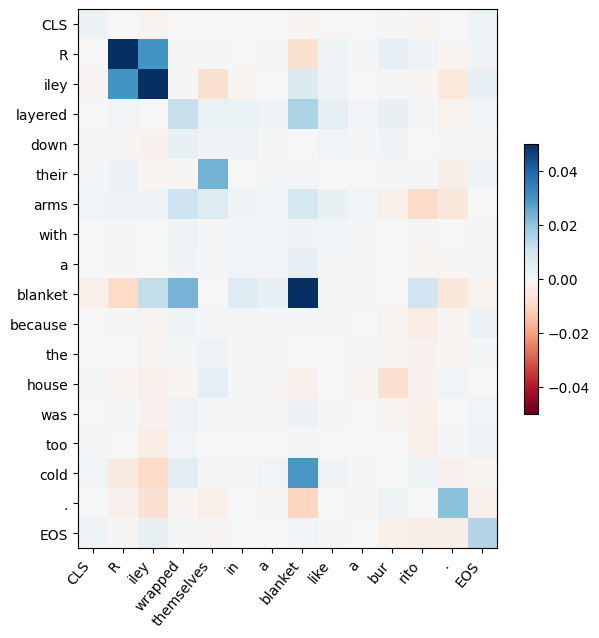

In [9]:
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [10]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.5962585210800171
total attribution:  0.6104193329811096
reference terms:  0.0 0.0 0.0
attribution error:  0.01416081190109253


100%|██████████| 768/768 [00:06<00:00, 119.92it/s]


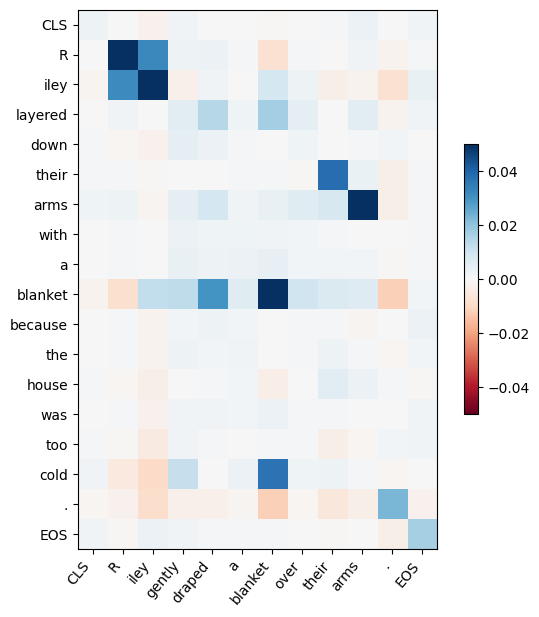

In [8]:
texta = 'Riley layered down their arms with a blanket because the house was too cold.'
textb = 'Riley gently draped a blanket over their arms.'

A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)

utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [9]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.8359216451644897
total attribution:  0.8554898500442505
reference terms:  0.0 0.0 0.0
attribution error:  0.019568204879760742


100%|██████████| 768/768 [00:06<00:00, 120.04it/s]


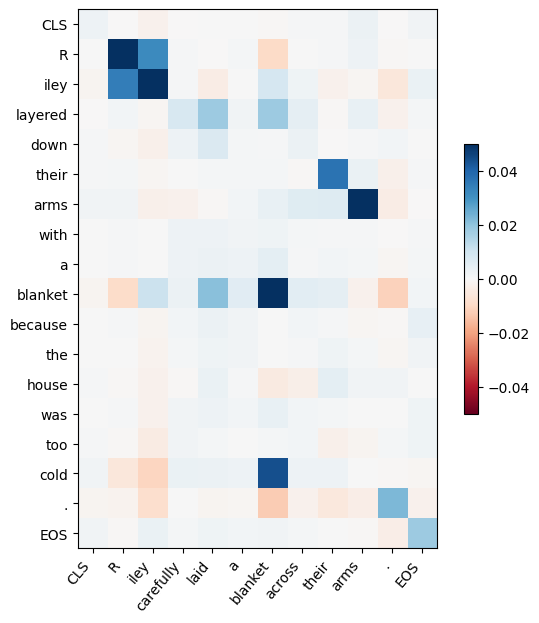

In [8]:
texta = 'Riley layered down their arms with a blanket because the house was too cold.'
textb = 'Riley carefully laid a blanket across their arms.'

A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [9]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.8188379406929016
total attribution:  0.8383126258850098
reference terms:  0.0 0.0 0.0
attribution error:  0.019474685192108154


100%|██████████| 768/768 [00:06<00:00, 119.97it/s]


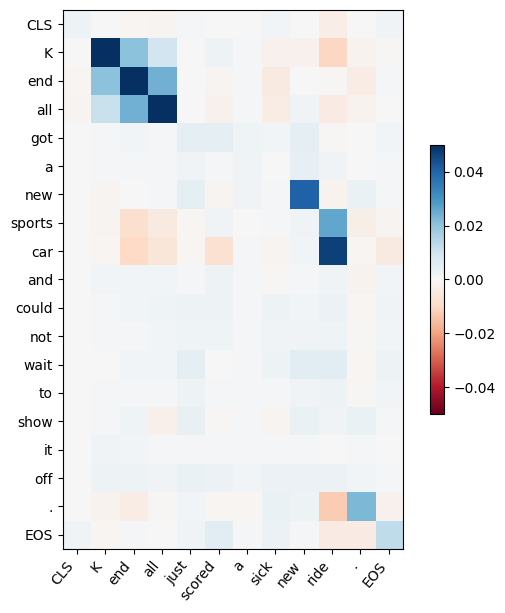

In [7]:
texta = 'Kendall got a new sports car and could not wait to show it off.'
textb = 'Kendall just scored a sick new ride.'

A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [8]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.5406897068023682
total attribution:  0.556084156036377
reference terms:  0.0 0.0 0.0
attribution error:  0.015394449234008789


100%|██████████| 768/768 [00:07<00:00, 100.52it/s]


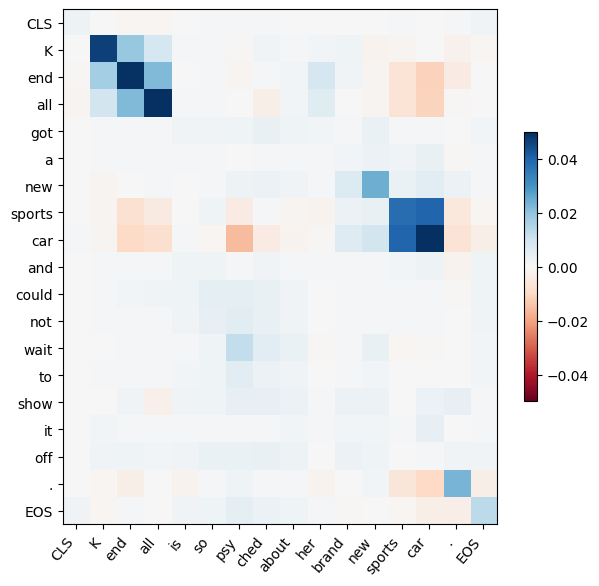

In [7]:
texta = 'Kendall got a new sports car and could not wait to show it off.'
textb = 'Kendall is so psyched about her brand new sports car.'

A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [8]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.7299102544784546
total attribution:  0.7501495480537415
reference terms:  0.0 0.0 0.0
attribution error:  0.020239293575286865


100%|██████████| 768/768 [00:06<00:00, 110.33it/s]


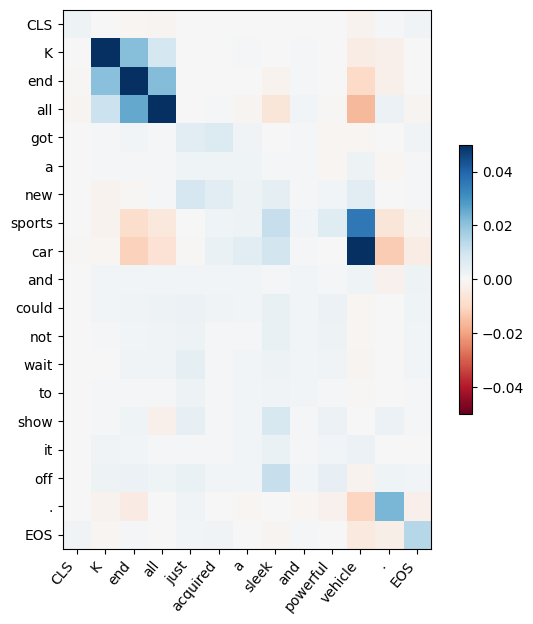

In [9]:
texta = 'Kendall got a new sports car and could not wait to show it off.'
textb = 'Kendall just acquired a sleek and powerful vehicle.'

A, tokens_a, tokens_b, score, ra, rb, rr = model.attribute_prediction(
    texta, 
    textb, 
    move_to_cpu=False,
    compute_lhs=True
)
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.05,
    show_colobar=True, 
    shrink_cbar=.5
)

In [10]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.6047537326812744
total attribution:  0.6224566698074341
reference terms:  0.0 0.0 0.0
attribution error:  0.017702937126159668


### attribution accuracy

The first term, $f(a, b)$ (`score`), is the actual model prediction.
Due to the embedding shift implemented in the `models.ShiftingReferenceTransformer` (cf. Section 2.2 in the paper), by construction, the three terms including a reference $r$ must vanish. Below, we explicitly check that this is the case.

We can also calculate how accurate our attributions are by taking the absolute difference between their sum and the model (as described in Section 3.2 of the paper): $\text{error} = \|\sum_{ij} A_{ij} - f(a, b)\|$.

You can change the number of approximation steps $N$ in the `init_attribution_to_layer()` method to see how this attribution error changes.
Generally, attributions to shallower layers require larger $N$ (cf. Section 3.2 in the paper).

In [7]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.8484635353088379
total attribution:  0.8538110852241516
reference terms:  0.0 0.0 0.0
attribution error:  0.005347549915313721


### plotting attributions

Finally, we can plot the token-token attribution matrix.

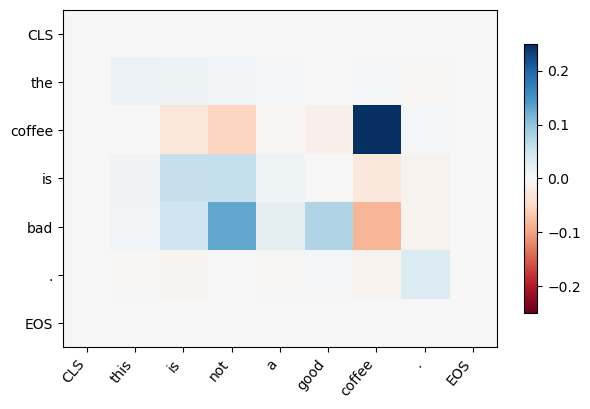

In [8]:
utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    # size=(2, 2),
    range=.25,
    show_colobar=True, 
    shrink_cbar=.5
)